Implementation of KNN from Scratch for my own learning.

In [89]:
import numpy as np
import polars as pl
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
wine_data = load_wine()

wine_df = pl.DataFrame({
    **{name: wine_data.data[:,i] for i,name in enumerate(wine_data.feature_names)},
    'target':wine_data.target 
})

Plot this Wine Data

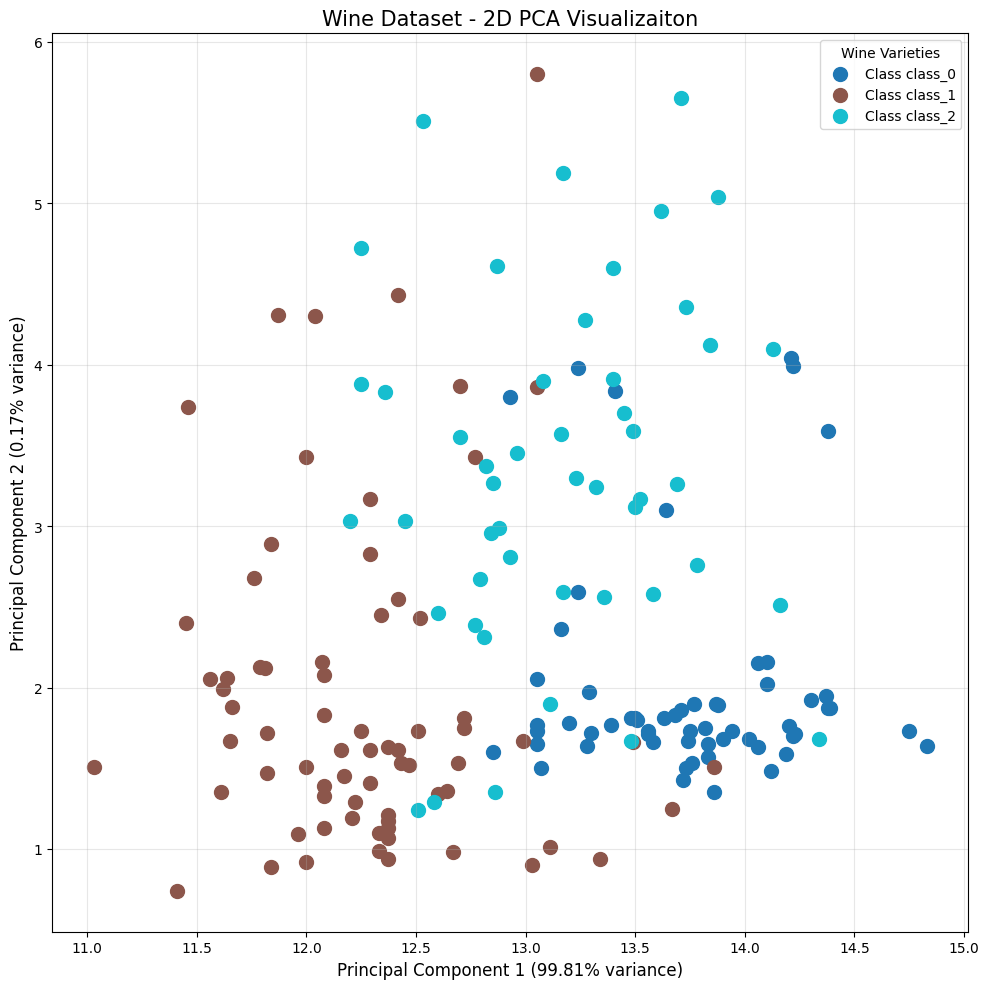

In [90]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = wine_df.select(pl.exclude('target')).to_numpy()
y = wine_df.select('target').to_numpy().flatten()



X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=50)


#In order to not give model sneak peak at test data we must do it this way
#fit_transform for X_train_scaled
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plot_df = pl.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Class": y
})

plt.figure(figsize = (10,10))
unique_classes = np.unique(y)
colors = np.array(plt.cm.tab10(np.linspace(0,1,len(unique_classes))))
class_names = wine_data.target_names

for i , unique_class in enumerate(unique_classes):
    bool_values = (y == unique_class)
    plt.scatter(
        X[bool_values,0],
        X[bool_values,1],
        color = colors[i],
        label = f"Class {class_names[i]}",
        s = 100
    )
plt.title('Wine Dataset - 2D PCA Visualizaiton', fontsize = 15)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.legend(title="Wine Varieties")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Implement Class KNN

In [91]:
class KNN:
    def __init__(self,k = 5, distance_metric = 'euclidian', weighted = False):
        self.k = k
        self.distance_metric = distance_metric
        self.weighted = weighted
        self.X_train = None
        self.y_train = None
    
    #Fit the training data 
    def fit(self,X,y):
        self.X_train = X
        self.y_train = y

    #L2 Norm
    def _euclidian_distance(self,x1,x2):
        return np.sqrt(np.sum((x1-x2)*(x1-x2)))

    #L1 Norm
    def _manhattan_distance(self,x1,x2):
        return np.sum(np.abs(x1-x2))
    
    #takes two vectors(np arrays) and returns the distance
    def _calculate_distance(self,x1,x2):
        if self.distance_metric == 'euclidian':
            return self._euclidian_distance(x1,x2)
        elif self.distance_metric == 'manhattan':
            return self._manhattan_distance(x1,x2)
        else:
            raise ValueError(f'{self.distance_metric} is not a valid distance metric')
    
    #given a singular point x return index of k neighbors and their distance from a vector of xts
    def _get_neighbors(self,x):
        distances = np.array([self._calculate_distance(x,xt) for xt in self.X_train])

        indicies_of_closest = np.argsort(distances)[:self.k]
        values_of_closest = distances[indicies_of_closest]
        neighbor_labels = self.y_train[indicies_of_closest]

        return neighbor_labels , values_of_closest
    
    #given some new unseen data return an array of classifications
    def predict(self,X):
        y_pred = np.zeros(X.shape[0], dtype = self.y_train.dtype)

        for i , x_row in enumerate(X):
            neighbor_labels , values_of_closest = self._get_neighbors(x_row)

            #if we are a weighted model, calculate weigths and sum based on their class. 
            #Closer values have a higher weight and greater sum; sum weights for unique classes.
            #get the unique class which had the highest sum
            if self.weighted:
                weights_of_closest = (1 / values_of_closest)

                unique_labels = np.unique(neighbor_labels)
                class_weights = np.zeros(len(unique_labels))

                for j , unique_class in enumerate(unique_labels):
                    class_weights[j] = np.sum(weights_of_closest[neighbor_labels == unique_class])
                
                y_pred[i] = unique_labels[np.argmax(class_weights)]
            #we are not weighted, simply get unique classes and their count.
            #set our prediction to the prediction label with the highest count
            else:
                prediction_labels , counts = np.unique(neighbor_labels,return_counts=True)
                y_pred[i] = prediction_labels[np.argmax(counts)]
        
        return y_pred
    def accuracy_score(self, X , y_true):
        y_pred = self.predict(X)
        return np.mean(y_pred == y_true)


<h1 style="color: white; font-size: x-large">Test Our Model</h1>

In [92]:

my_KNN = KNN(10, distance_metric='euclidian', weighted= True)

my_KNN.fit(X_train_scaled,y_train)
predictions = my_KNN.predict(X_test_scaled)
accuracy = my_KNN.accuracy_score(X_test_scaled,y_test)

print(f"Accuracy is {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=wine_data.target_names))



Accuracy is 0.9630

Classification Report:
              precision    recall  f1-score   support

     class_0       0.94      1.00      0.97        16
     class_1       1.00      0.91      0.95        23
     class_2       0.94      1.00      0.97        15

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54



<h1 style="color: green; font-size: x-large">Try different K values</h1>

Printing top 10 k values by accuracy

accuracy for k value 23 is 0.9814814814814815 

accuracy for k value 11 is 0.9814814814814815 

accuracy for k value 31 is 0.9814814814814815 

accuracy for k value 32 is 0.9814814814814815 

accuracy for k value 33 is 0.9814814814814815 

accuracy for k value 22 is 0.9814814814814815 

accuracy for k value 20 is 0.9814814814814815 

accuracy for k value 16 is 0.9814814814814815 

accuracy for k value 15 is 0.9814814814814815 

accuracy for k value 13 is 0.9814814814814815 



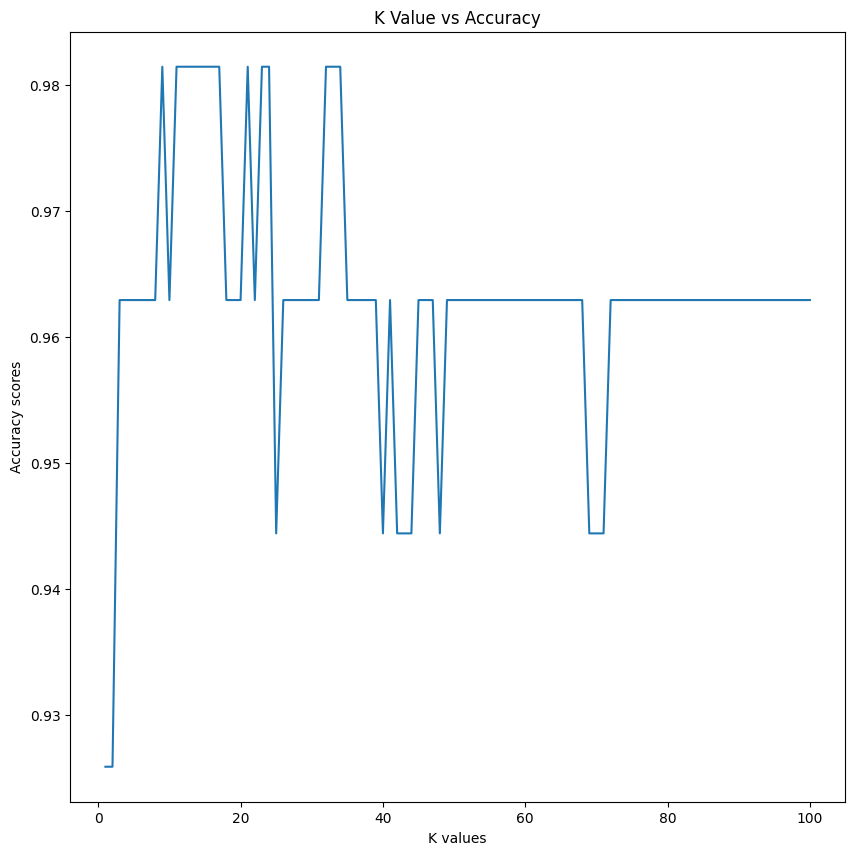

In [93]:
#Values 1 - 100
k_values = np.linspace(1,100,100,dtype = int)
accuracies = []

for k in k_values:
    knn_Instance = KNN(k,distance_metric = 'euclidian',weighted = True)
    knn_Instance.fit(X_train_scaled,y_train)
    accuracy = knn_Instance.accuracy_score(X_test_scaled,y_test)
    accuracies.append(accuracy)

accuracies = np.array(accuracies)


best_accuracy_indicies = np.array((np.argsort(accuracies)[::-1])[:10])
best_accuracies = accuracies[best_accuracy_indicies]


print('Printing top 10 k values by accuracy\n')
for i in range(len(best_accuracy_indicies)):
    print(f"accuracy for k value {best_accuracy_indicies[i]} is {best_accuracies[i]} \n")

plt.figure(figsize = (10,10))
plt.plot(k_values,accuracies)
plt.title('K Value vs Accuracy')
plt.xlabel('K values')
plt.ylabel('Accuracy scores')
plt.show()